In [2]:
import unicodedata
import string
import os
import glob

In [3]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [19]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize('NFD', s)
                   if c in all_letters and
                   unicodedata.category(c) != 'Mn')


def readFiles(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [20]:
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    print(filename)
    category = os.path.splitext(os.path.basename(filename))[0]
    lines = readFiles(filename)
    category_lines[category] = lines
    all_categories.append(category)
    
n_categories = len(all_categories)

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [21]:
n_categories, all_categories

(18,
 ['Czech',
  'German',
  'Arabic',
  'Japanese',
  'Chinese',
  'Vietnamese',
  'Russian',
  'French',
  'Irish',
  'English',
  'Spanish',
  'Greek',
  'Italian',
  'Portuguese',
  'Scottish',
  'Dutch',
  'Korean',
  'Polish'])

In [22]:
len(category_lines['Polish'])

139

In [23]:
# converting each line to a tensor of shape (len(line), 1, n_letters)
import torch


def getIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    out = torch.zeros(1, n_letters)
    out[0][getIndex(letter)] = 1
    return out


def lineToTensor(line):
    out = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        out[li][0][getIndex(letter)] = 1
    return out

print(n_letters)
print(letterToTensor('J'))

print(lineToTensor('Jones').shape)

57
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [29]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [34]:
# testing the model

input = lineToTensor('Albert')
print(input.shape)
hidden = torch.zeros(1, n_hidden)
print(hidden.shape)

output, next_hidden = rnn(input[0], hidden)
print(output.shape)
print(output)

torch.Size([6, 1, 57])
torch.Size([1, 128])
torch.Size([1, 18])
tensor([[-2.9154, -2.8743, -2.8237, -2.8530, -2.8962, -2.9506, -2.8035, -2.9630,
         -2.8906, -2.9024, -2.8919, -2.9502, -2.9044, -3.0063, -2.7776, -2.8952,
         -2.9429, -2.8164]], grad_fn=<LogSoftmaxBackward>)


In [58]:
output.topk(3, 1)

torch.return_types.topk(
values=tensor([[-0.2966, -1.9662, -3.6050]], grad_fn=<TopkBackward>),
indices=tensor([[ 8,  7, 13]]))

In [43]:
# helper functions for model training
import random


def categoryFromOutput(output):
    top_n, top_i = torch.topk(output, 1)
    category_i = top_i[0].item()
    category = all_categories[category_i]
    return category, category_i


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],
                                   dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [46]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Ha
category = Greek / line = Sakelaris
category = Portuguese / line = Madeira
category = French / line = Lefebvre
category = Vietnamese / line = Dinh
category = German / line = Kneib
category = Greek / line = Sardelis
category = Greek / line = Banos
category = Japanese / line = Takekawa
category = Vietnamese / line = Trinh


In [49]:
line_tensor.size(0)

5

In [50]:
# training

criterion = nn.NLLLoss()
LR = 0.005


def train(line_tensor, category_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # update the model params
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-LR)
    
    return output, loss.item()

In [51]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.2831 Chi / Vietnamese ✗ (Korean)
10000 10% (0m 14s) 2.4252 Preece / Portuguese ✗ (English)
15000 15% (0m 21s) 2.1289 Anstee / German ✗ (English)
20000 20% (0m 28s) 1.6459 Deushi / Arabic ✗ (Japanese)
25000 25% (0m 35s) 2.1782 Boyd / Korean ✗ (English)
30000 30% (0m 42s) 0.5108 Kassab / Arabic ✓
35000 35% (0m 49s) 1.7436 Mendes / Dutch ✗ (Portuguese)
40000 40% (0m 57s) 3.4969 Rutman / German ✗ (Russian)
45000 45% (1m 4s) 2.1909 Fashingbauer / French ✗ (German)
50000 50% (1m 12s) 0.8532 Bishara / Arabic ✓
55000 55% (1m 20s) 2.1961 Skala / Czech ✗ (Polish)
60000 60% (1m 27s) 2.7509 Neil / Chinese ✗ (Irish)
65000 65% (1m 34s) 1.5698 Brisbois / Greek ✗ (French)
70000 70% (1m 41s) 2.7535 Bacon / Arabic ✗ (Czech)
75000 75% (1m 48s) 0.4735 Seighin / Irish ✓
80000 80% (1m 56s) 1.6256 Bithell / German ✗ (English)
85000 85% (2m 3s) 0.4618 Nuallan / Irish ✓
90000 90% (2m 10s) 2.3689 Li / Vietnamese ✗ (Korean)
95000 95% (2m 17s) 0.1846 Rossini / Italian ✓
100000 100% (2m 23s) 3.88

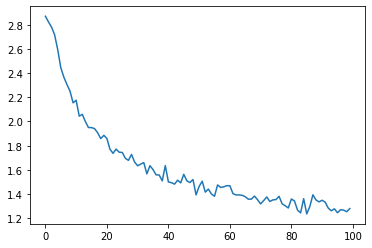

In [52]:
# plotting the results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-53-7d26e702161f>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+all_categories, rotation=90)
<ipython-input-53-7d26e702161f>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+all_categories)


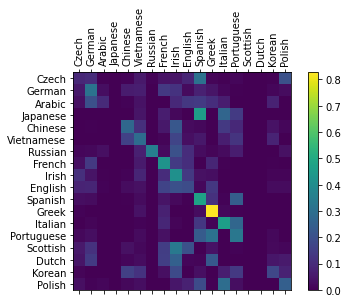

In [53]:
# Evaluation
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size(0)):
        output, loss = rnn(line_tensor[i], hidden)
    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    logits = evaluate(line_tensor)
    pred, pred_i = categoryFromOutput(logits)
    category_i = all_categories.index(category)
    confusion[category_i][pred_i] += 1
    
# Normalize by rows
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels(['']+all_categories, rotation=90)
ax.set_yticklabels(['']+all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [59]:
def predict(input_line, n_predictions=3):
    pre_inp = unicodeToAscii(input_line)
    logits = evaluate(lineToTensor(pre_inp))
    pred, pred_i = logits.topk(n_predictions, 1)
    
    print('\n> %s' % (input_line))
    for i in range(n_predictions):
        value, index = pred[0][i].item(), pred_i[0][i].item()
        category_i = all_categories[index]
        print('(%0.2f) %s' % (value, category_i))


In [60]:
predict('Dovesky')


> Dovesky
(-1.80) English
(-1.81) Irish
(-2.16) Scottish


In [61]:
predict('Jackson')


> Jackson
(-1.66) Irish
(-2.11) Dutch
(-2.13) English
